In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import seaborn as sns
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import contextily as cx
import matplotlib.colors as colors
from pandarallel import pandarallel
import numpy as np
from swifter import swifter

sns.set_theme()

In [2]:
%%time
data = pd.read_csv('../../../data/data_with_weather.csv', sep=',')
data = data[['lat','lon']]
#data['timestamps_UTC'] = pd.to_datetime(data.timestamps_UTC)
#data['mapped_veh_id'] = data.mapped_veh_id.apply(lambda x: str(int(x)))
#data['lat'] = data.lat +0.5
#data['day'] = data['timestamps_UTC'].dt.strftime('%y-%m-%d')
data.head()

CPU times: user 17 s, sys: 34.8 s, total: 51.7 s
Wall time: 54.7 s


,lat,lon
0,50.769818,3.872114
1,51.039993,3.693429
2,50.742203,3.602035
3,50.930914,5.327132
4,51.180773,3.575259


CPU times: user 331 ms, sys: 381 ms, total: 712 ms
Wall time: 741 ms


<Axes: >

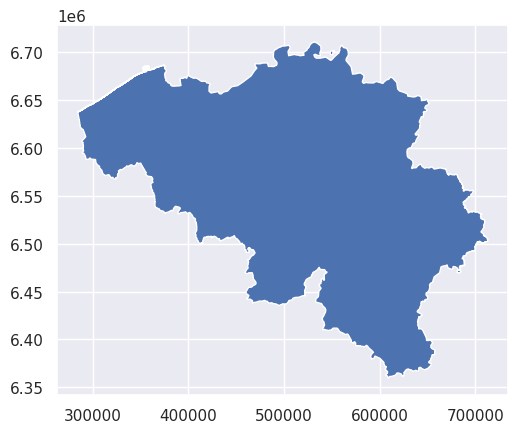

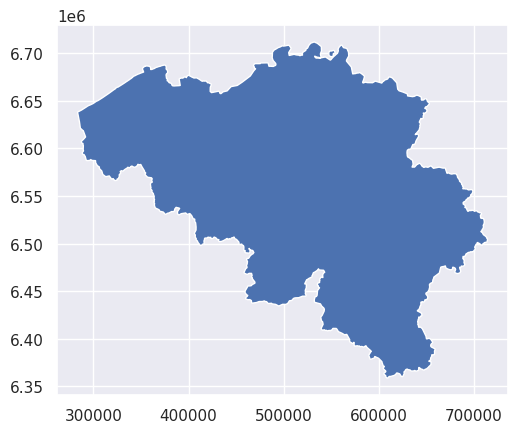

In [3]:
%%time
belgium = gpd.read_file('gadm41_BEL.gpkg')
belgium_crs = belgium.to_crs("EPSG:3857") 
belgium_buffer = belgium_crs.buffer(1000)
belgium_crs.plot()
belgium_buffer.plot()

In [4]:
%%time
#pandarallel.initialize(progress_bar=True, nb_workers=4, use_memory_fs=False)

geo_data = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.lon, data.lat), crs="EPSG:4326"
)

geo_data['geometry'] = geo_data.geometry.to_crs("EPSG:3857")
del data


CPU times: user 13 s, sys: 7.64 s, total: 20.7 s
Wall time: 20.7 s


In [5]:
%%time
def add_inside (row):
    return belgium_buffer.contains(row['geometry'])
geo_data['inside'] = geo_data.swifter.apply(add_inside, axis =1)
geo_data.head()

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

CPU times: user 1min 55s, sys: 3.42 s, total: 1min 58s
Wall time: 19min 11s


,lat,lon,geometry,inside
0,50.769818,3.872114,POINT (431041.803 6580677.803),True
1,51.039993,3.693429,POINT (411150.580 6628371.143),True
2,50.742203,3.602035,POINT (400976.669 6575818.415),True
3,50.930914,5.327132,POINT (593013.599 6609082.348),True
4,51.180773,3.575259,POINT (397995.967 6653332.794),True


In [6]:
geo_data['inside'].value_counts()

inside
True     17679260
False          13
Name: count, dtype: int64

<Axes: >

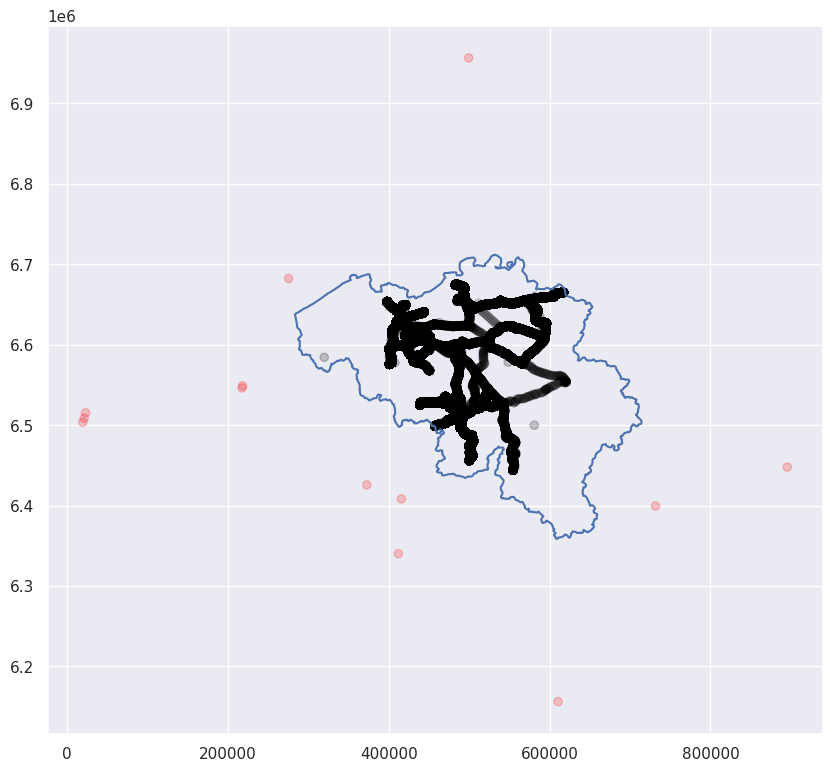

In [7]:
# 4313 https://epsg.io/4313
color_dict = {True:'red', False:'black'}
df_wm = geo_data.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(10, 10), alpha=0.2, column="inside", cmap=colors.ListedColormap(list(color_dict.values())))
belgium_buffer.boundary.plot(ax = ax)

In [15]:
# you can see the with the command sed '377875q;d' data_with_weather.csv  add to, one for the header, and one for 0 indexing
geo_data[geo_data.inside == False].to_csv('data_outside_belgium.csv')

In [16]:
geo_data[geo_data.inside == False]

,lat,lon,geometry,inside
377873,49.383591,3.700235,POINT (411908.287 6340201.134),False
1239993,49.780084,3.734780,POINT (415753.863 6408277.082),False
2929855,52.857059,4.485541,POINT (499328.151 6956601.311),False
3213259,50.397906,0.206793,POINT (23020.069 6515473.513),False
4484586,50.330024,0.175049,POINT (19486.377 6503627.574),False
8953244,48.295677,5.484127,POINT (610490.169 6156186.626),False
8972089,50.008925,8.045492,POINT (895620.061 6447821.707),False
9355621,49.881053,3.347395,POINT (372630.340 6425701.811),False
9624290,51.343530,2.474403,POINT (275449.226 6682286.665),False
12241898,50.573667,1.954037,POINT (217522.359 6546224.103),False


In [8]:
%%time
#small_trajectory = data [(data['mapped_veh_id'] == '114') & (data['day']=='23-04-03')]
#small_trajectory = mpd.TrajectoryCollection(data, 'mapped_veh_id', t='timestamps_UTC', x='lat', y='lon', min_length=10)
#print(small_trajectory)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [9]:
#small_trajectory.plot(column='mapped_veh_id', legend=False, figsize=(18,10))
#plt.tight_layout()

In [10]:
#small_trajectory.trajectories[1]